In [26]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
from sys import getsizeof

import diurnal_config

# from diurnal_utils import *
%run diurnal_utils.py
from fetch_model_helper import *

# Notebook for exploring local CMIP6 data downloaded with `cmip6_downloader.py`

In [27]:
cmip_identifier = 'CMIP5'
# cmip_identifier = 'CMIP6'
start_date = '1985-01'
end_date = '2006-01'

# end_date = '1990-01'
# end_date = '1985-01'


In [28]:
cmip6_model_names = diurnal_config.cmip6_to_cmip5_map.keys()
cmip5_model_names = diurnal_config.cmip6_to_cmip5_map.values()



if cmip_identifier == 'CMIP6':
    all_model_names = list(cmip6_model_names)
    cmip_rel_dir = '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'

elif cmip_identifier == 'CMIP5':
    all_model_names = list(cmip5_model_names)
    cmip_rel_dir = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'
    


In [29]:
model_name = 'SAM0-UNICON'
if cmip_identifier == 'CMIP6':
    path_to_cmip_files =  get_path_to_desired_model_cmip6(cmip_rel_dir, 
                          desired_model= model_name,
                          desired_ensemble_member = ('r1i1p1f1', 'r1i1p2f1','r1i1p1f2'),
                          desired_grid_types = ('gn', 'gr', 'gr1', 'gr2'))
elif cmip_identifier == 'CMIP5':
    path_to_cmip_files = get_path_to_desired_model_cmip5(cmip_rel_dir, 
                      desired_model=model_name,
                      desired_ensemble_member = ('r1i1p1','r6i1p1','r2i1p1'))
# subset lat/lon and time
print('Opening data...')
ds = xr.open_mfdataset(path_to_cmip_files, combine='by_coords')
ds = ds.sel(time = slice(start_date, end_date))
ds = ds.sel(lat= slice(-60, 60))

# perform diurnal analysis 
print('Performing diurnal analysis... ')
ds_sub = ds['pr'].to_dataset()

Opening data...
Performing diurnal analysis... 


## Timing Stats
#### 10min 55s - time_resolution_hours = 1
#### xxx - time_resolution_hours = 0.1

In [169]:
%%time
grid_time_resolution_hours = 3
time_resolution_hours = 0.2
field_id = 'pr'

hour_bins = np.arange(time_resolution_hours, 24 + time_resolution_hours, time_resolution_hours)
grid_hour_bins = np.arange(grid_time_resolution_hours, 24 + grid_time_resolution_hours, grid_time_resolution_hours)

lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}
ampl_season = {}
phase_season = {}
ampl_cov_season = {}
phase__cov_season = {}
average_cycle_season = {}

for season_i, season_ds in ds_seasons:
    if season_i != 'DJF':
        break
    print(season_i)
    lst_da = compute_lst_array(season_ds, 
                               bin_interval = grid_time_resolution_hours, # time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    del lst_da
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    #         field_season_mean = field_season_array.mean(axis = 0)

    # compute mu_ij
    #         mu_ij = np.zeros(field_season_array.shape[-2:])
    mu_ij = np.zeros(field_season_array.shape[-2:])
    #         sigma_ij = np.zeros((len(hour_bins),) + field_season_array.shape[-2:])

    f_bar_ks = {}
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k
        mu_ij  += f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))
    average_cycle_season[season_i] = hour_means


    mu_ij = (1/len(grid_hour_bins))*mu_ij
    #         mu_ij = (1/8)*mu_ij
    mu_season[season_i] = mu_ij

    sigma_ij = np.zeros(field_season_array.shape[-2:])
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        sigma_ij += np.square(f_bar_k - mu_ij)

    sigma_ij = np.sqrt((1/(len(grid_hour_bins) - 1))*sigma_ij)
    #         sigma_ij = np.sqrt((1/7)*sigma_ij)
    #         sigma_ij = np.nanstd(sigma_ij, axis = 0)

    sigma_season[season_i] = sigma_ij

    lst_da = compute_lst_array(season_ds, 
                               bin_interval = time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    del lst_da
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    #         field_season_mean = field_season_array.mean(axis = 0)

    # compute hourly grid means needed for cos fit
    f_bar_ks = {}
    for ii in range(len(hour_bins)):
        hour_i = hour_bins[ii]
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_ks[hour_i] = f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))

    print('Performing Cos Fit')
    #         res = cos_fit_grid(field_season_array, lst_array, hour_means, hour_bins)
    res = cos_fit_grid_average(hour_means, hour_bins)
    print('Finished Cos Fit')
    ampl_season[season_i], phase_season[season_i] = res[0], res[1]

    #TODO : Move this over! Should not do every iteration of the loop
    # make results into dataarrays
    out_ds = xr.Dataset()
    out_ds['mu_season'] = make_da_from_dict(mu_season, ds)
    out_ds['sigma_season'] = make_da_from_dict(sigma_season,ds)
    out_ds['ampl_season'] = make_da_from_dict(ampl_season, ds)
    out_ds['phase_season'] = make_da_from_dict(phase_season,ds)

    out_ds_means = xr.Dataset()
    out_ds_means = make_da_from_dict_time(average_cycle_season, ds, grid_hour_bins)
    out_ds_means = out_ds_means.to_dataset(name = field_id + '_mean')


DJF


100%|██████████| 15368/15368 [00:59<00:00, 259.72it/s]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
  0%|          | 0/128 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 128/128 [01:34<00:00,  1.36it/s]

Finished Cos Fit
CPU times: user 14min 9s, sys: 7min 14s, total: 21min 24s
Wall time: 20min 44s


In [215]:
%run diurnal_utils.py
r1 = cos_fit_grid_average(hour_means, hour_bins)

100%|██████████| 128/128 [00:37<00:00,  3.39it/s]


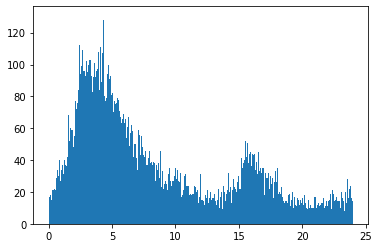

In [205]:
_ = plt.hist(r1[1].flatten(), bins = 1000)

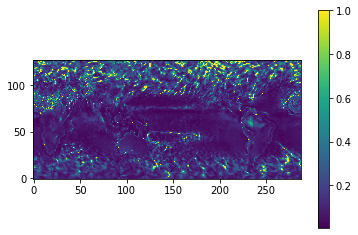

In [226]:
plt.imshow(np.sqrt(r1[3]), origin = 'lower', vmax = 1)
plt.colorbar()

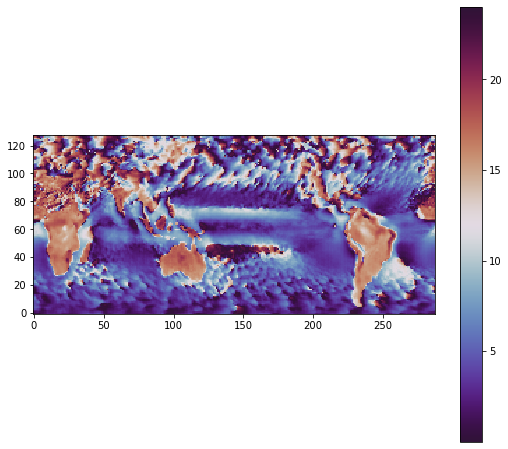

In [234]:
plt.figure(figsize = (9,8))
plt.imshow(r1[1], origin = 'lower', cmap = plt.get_cmap('twilight_shifted'))
plt.colorbar()

In [170]:
season_i = 0
ds_i_season = out_ds['phase_season'].isel(season =0)

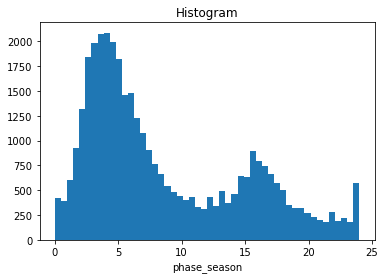

In [177]:
_ = ds_i_season.plot.hist(bins = 50)# plt.xlim([0,6])

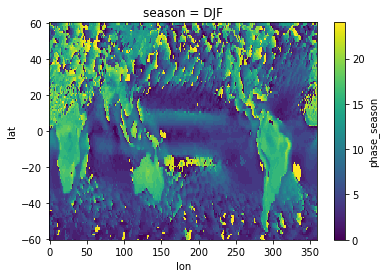

In [103]:
# out_ds['phase_season'].round(round_pres).where(out_ds['phase_season'].round(round_pres) == 24)
# ds_i_season.round(round_pres).where(out_ds['phase_season'].round(round_pres) == 24)
# ds_i_season.round(round_pres).plot.hist

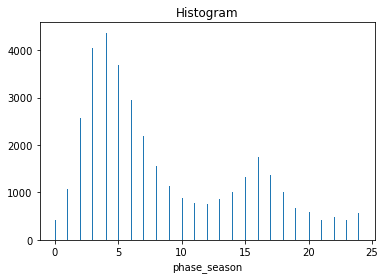

<Figure size 432x288 with 0 Axes>

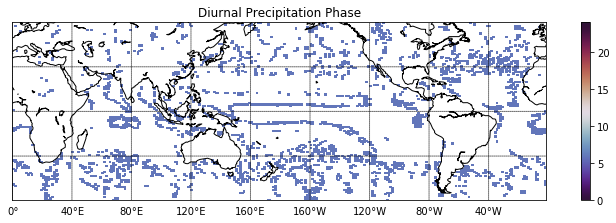

In [178]:
round_pres = 0

plt.figure()
_ =  ds_i_season.round(round_pres).plot.hist(bins = 300)

plt.figure()
make_single_plot(ds_i_season.round(round_pres).where(ds_i_season.round(round_pres) == 6), 
                 title = r'Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

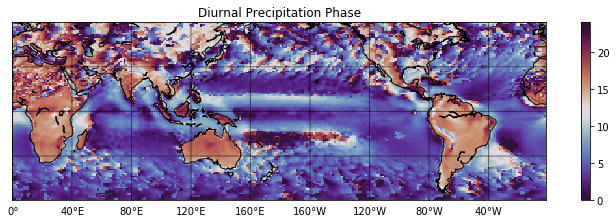

In [227]:
make_single_plot(ds_i_season, 
                 title = r'Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

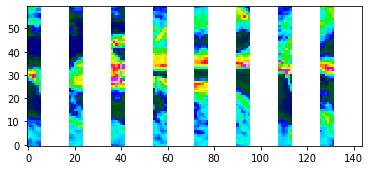

In [33]:
# plt.imshow(np.nanmean(hour_means[:1,:,:], axis = 0), 
#            origin = 'lower', 
#            cmap = 'gist_ncar')

plt.imshow(hour_means[1,:,:], 
           origin = 'lower', 
           cmap = 'gist_ncar')

In [125]:
# time_ind = 3
# print(season_ds.isel(time = time_ind))

# dt_i = datetime.strptime(str(season_ds.isel(time = time_ind)['time'].values.item()), '%Y-%m-%d %H:%M:%S')
# # dt_i
# rr = calc_solar_time_ephem(dt_i, lon_mesh, bin_interval = time_resolution_hours, bin_bool = True)
# plt.imshow(rr, origin = 'lower')

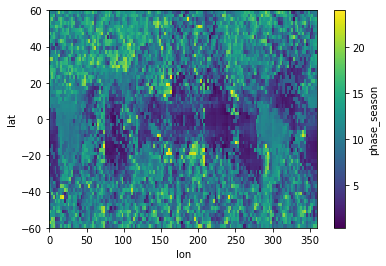

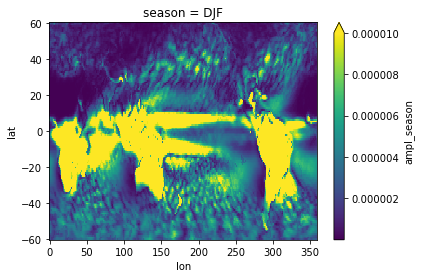

In [182]:
out_ds['ampl_season'].isel(season =0).plot.imshow(vmax = 0.00001)


In [185]:
np.any(np.isnan(out_ds['phase_season']))

<xarray.DataArray 'phase_season' ()>
array(False)

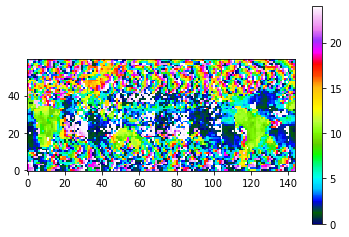

In [222]:
plt.imshow(phase_season['DJF'], origin = 'lower', cmap = plt.get_cmap('gist_ncar'))
plt.colorbar()

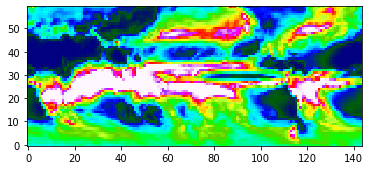

In [227]:
plt.imshow(np.nanmean(hour_means[:,:,:],axis = 0), origin = 'lower', vmax = 0.0001, cmap = plt.get_cmap('gist_ncar'))

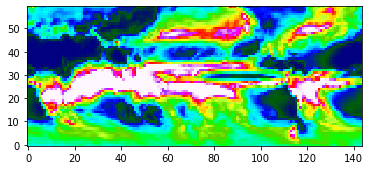

In [228]:
plt.imshow(field_season_mean, origin = 'lower', vmax = 0.0001, cmap = plt.get_cmap('gist_ncar'))

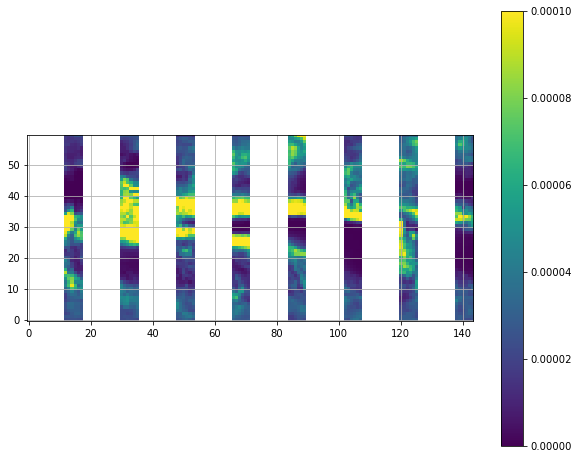

In [69]:
# hour_means.shape
plt.figure(figsize = (10,8))
plt.imshow(hour_means[12,:,:], origin = 'lower', vmax = 0.0001)
plt.grid()
plt.colorbar()

In [58]:
# hour_means

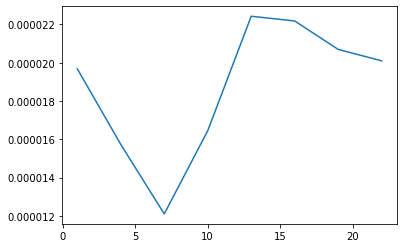

In [55]:
ts_loc_mean_sub = hour_means[:,10,50]
non_nan_inds = np.where(np.isfinite(ts_loc_mean_sub))
plt.plot(hour_bins[non_nan_inds], ts_loc_mean_sub[non_nan_inds])

In [90]:
hour_means.shape

(24, 60, 144)

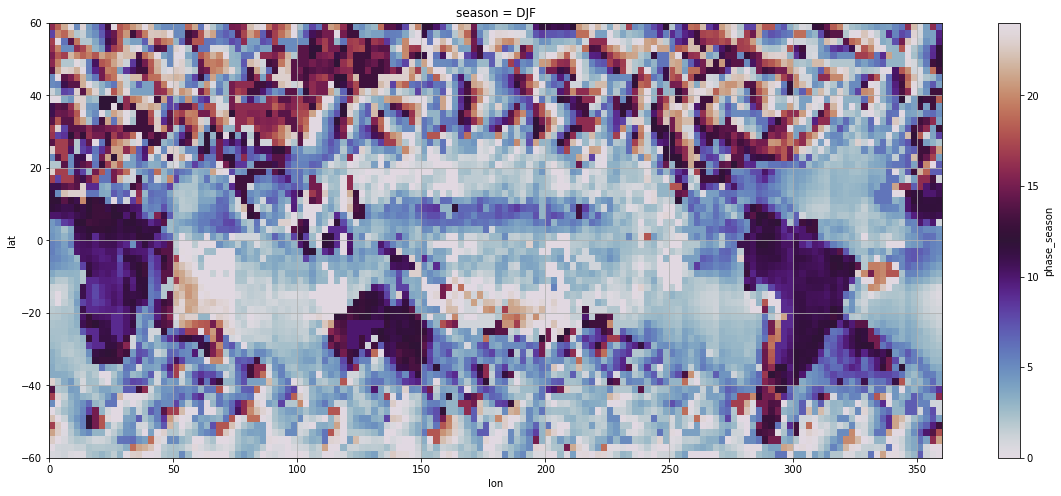

In [162]:
plt.figure(figsize = (20,8))
out_ds.isel(season = 0)['phase_season'].plot.imshow(cmap = plt.get_cmap('twilight'))
plt.grid()

In [156]:
# plt.figure(figsize = (20,8))
# out_ds.mean(dim = 'season')['phase_season'].plot.imshow(cmap = plt.get_cmap('twilight'))
# plt.grid()

20 19
[3.15181101e-06 2.68029503e+00]


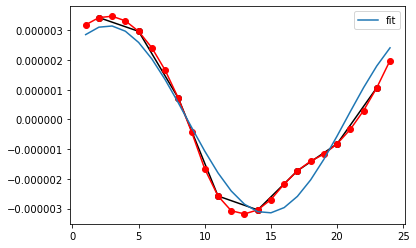

In [145]:
lat_sel = -20
lon_sel = 51

lon_ind = np.argmin(abs(ds['lon'].values - lon_sel))
lat_ind = np.argmin(abs(ds['lat'].values - lat_sel))
print(lon_ind, lat_ind)

ts_loc = hour_means[:,lat_ind,lon_ind]

hours_to_radians = 2*np.pi/24

ts_loc_mean_sub = ts_loc - np.nanmean(ts_loc)
non_nan_inds = np.where(np.isfinite(ts_loc_mean_sub))

f = interpolate.interp1d(hour_bins[non_nan_inds], 
                         ts_loc_mean_sub[non_nan_inds], 
                         kind = 'quadratic',
                         fill_value="extrapolate")

ts_loc_mean_sub_interp = f(hour_bins)

params, params_covariance = optimize.curve_fit(cos_func, 
                                               hour_bins, 
                                               ts_loc_mean_sub_interp,
                                               bounds = (0,24),
                                               p0=[ts_loc_mean_sub_interp.std(), 
                                                   hour_bins[np.nanargmax(ts_loc)]],
                                               maxfev=10000)
plt.plot(hour_bins[non_nan_inds], ts_loc_mean_sub[non_nan_inds], 'ko-')
plt.plot(hour_bins, ts_loc_mean_sub_interp , 'ro-')

print(params)
plt.plot(hour_bins, cos_func(hour_bins, *params), label = 'fit')
plt.legend()

In [145]:
hour_bins[np.nanargmax(ts_loc)]

24

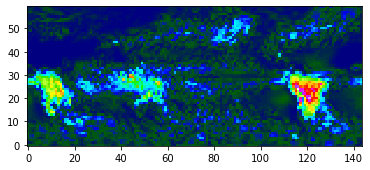

In [10]:
# ts_loc

plt.imshow(res[0], origin = 'lower',
           cmap = plt.get_cmap('gist_ncar'))

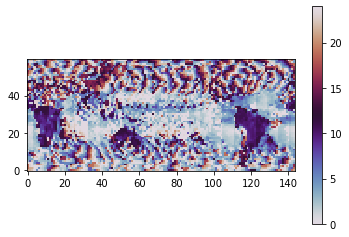

In [15]:
plt.imshow(res[1], origin = 'lower',
           cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
plt.colorbar()
# plt.axis([100, 120,20,30])